In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import merge
from sklearn.decomposition import PCA
from __future__ import division
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

Org_Level = 'Org Level 3'

#Andrew's directory: C:/Users/aclark/Box Sync/Clustering/Department-Clustering\\DataFile.csv
#Kyril's directory: C:\Users\KpanforRealz\Desktop\UCSF Intern\DataFile.csv
df = pd.read_csv('C:\Users\KpanforRealz\Desktop\UCSF Intern\DataFile.csv',
                parse_dates = ['Transaction Date'],
                thousands=',',
                encoding="ISO-8859-1")

supplier_filter = '|'.join(['FISHER SCIENTIFIC',
                            'VWR',
                            'SIGMA ALDRICH',
                            'BIOEXPRESS',
                            'LIFE TECHNOLOGIES CORP',
                            'USA SCIENTIFIC',
                            'DENVILLE',
                            'CLONTECH',
                            'GE HEALTHCARE BIO',
                            'NEW ENGLAND BIO',
                            'SPECTRUM CHEMICAL', 
                            'SPECTRUM LABORATORY',
                            'PROMEGA'
                            ])

df_filtered = df[df['Supplier Normalized Name'].str.contains(supplier_filter) & (df['Spend'] > 0)]

N_Suppliers = df_filtered['Supplier Normalized Name'].nunique()

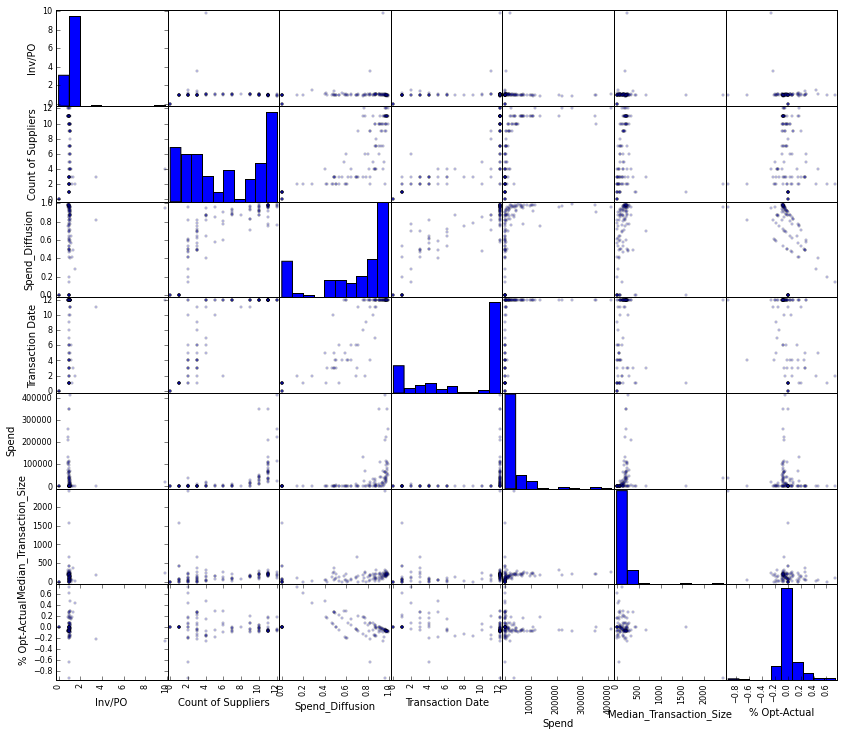

In [7]:
#Create a set of features for the total spend per supplier per department
Spend_per_Supplier = pd.pivot_table(df_filtered, values='Spend', index=['Campus', Org_Level], 
                                 columns='Supplier Normalized Name', aggfunc=np.sum, fill_value=0)

#Create the Invoice Per PO feature
PO_by_Inv = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0)
cutoff = 20
#Replace # of PO = 0 with a .01 so that we can avoid INF errors
PO_by_Inv.replace(0,1,True)
#Divide
PO_by_Inv['Inv/PO'] = (PO_by_Inv['# of Invoices']/PO_by_Inv['# of POs'])
#Take care of inf
PO_by_Inv['Inv/PO'].replace('inf',cutoff,True)
#Drop unnecessary columns
PO_by_Inv = PO_by_Inv.drop(['# of Invoices','# of POs'],1)
#Filter out the outliers and change them to a "cutoff"
PO_by_Inv['Inv/PO'][PO_by_Inv['Inv/PO'] > cutoff] = cutoff

#Create the median transaction size feature
Median_Transaction_Size = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['Spend'], aggfunc=np.median, fill_value=0)
Median_Transaction_Size = Median_Transaction_Size.rename(columns={'Spend':'Median_Transaction_Size'})

#Create the supplier count feature
Count_Supplier= DataFrame(pd.pivot_table(df_filtered, index=['Campus',Org_Level],values='Supplier Normalized Name',aggfunc=lambda x: len(x.unique())))
Count_Supplier = Count_Supplier.rename(columns={'Supplier Normalized Name':'Count of Suppliers'})

#Create the Spend Diffusion Metric
Max_Supplier_Spend = pd.pivot_table(df_filtered, index=['Campus',Org_Level,'Supplier Normalized Name'], 
                                          values=['Spend'], aggfunc=np.max, fill_value=0).reset_index().groupby(['Campus',Org_Level]).max().drop(['Supplier Normalized Name'],1)
Total_Dept_Spend = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['Spend'], aggfunc=np.sum, fill_value=0)
Spend_Diffusion = 1-(Max_Supplier_Spend/Total_Dept_Spend)
Spend_Diffusion = Spend_Diffusion.rename(columns={'Spend':'Spend_Diffusion'})
Log_Spend_Diffusion = pd.DataFrame(np.log(Spend_Diffusion))

#Create Spend Frequency and Average Monthly Spend/PO/Invoice Features
Dept_Summary = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()
#pivot out by campus, department, and date then find the summary stats of the time based dimensions
#Create a frame that is grouped by month and sum of all values
dept_time = pd.pivot_table(df_filtered, index=['Campus',Org_Level,'Transaction Date' ], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()
dept_time = dept_time.groupby(['Campus',Org_Level,dept_time['Transaction Date'].map(lambda x: (x.month,x.year))]).sum().reset_index()
avg_monthly = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).mean()['Spend'])
Count_Months = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).count()['Transaction Date'])

#Merge all the features into the Department_Analysis Frame (Un-comment to run these)
Department_Analysis = pd.merge(Spend_per_Supplier,PO_by_Inv,left_index=True, right_index=True,how='left')
Department_Analysis = pd.merge(Department_Analysis,Count_Supplier,left_index=True, right_index=True,how='left')
Department_Analysis = pd.merge(Department_Analysis,Spend_Diffusion,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,Count_Months,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,avg_monthly,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,Median_Transaction_Size,left_index=True,right_index=True,how='left')

#For some reason 1/Department_Analysis['Count of Suppliers'] didn't work so I created column of all 1
Department_Analysis['one']=1
Department_Analysis['Optimal Diffusion']= Department_Analysis['one']-(Department_Analysis['one']/Department_Analysis['Count of Suppliers'])
Department_Analysis['% Opt-Actual']=(Department_Analysis['Optimal Diffusion']-Department_Analysis['Spend_Diffusion'])/Department_Analysis['Optimal Diffusion']
Department_Analysis['% Opt-Actual']=Department_Analysis['% Opt-Actual'].fillna(0)
Department_Analysis[Department_Analysis['Spend_Diffusion']== -np.inf] = 0
Department_Analysis[Department_Analysis['% Opt-Actual']== -np.inf] = 0

del Department_Analysis['one']
del Department_Analysis['Optimal Diffusion']

#Calculate the number of non-Supplier Spend dimensions
NonSupplier_Features = len(Department_Analysis.columns) - N_Suppliers

#Create a scatterplot matrix to analyze the features
scatter_matrix(Department_Analysis.ix[:,-NonSupplier_Features:], alpha=0.2, figsize=(14, 12))

#This is a standardization of each columnwise data element by subtracting the column mean and dividing by the column standard deviation.
for col in Department_Analysis.columns:
    Department_Analysis[col + '_stdard'] = (Department_Analysis[col] - Department_Analysis[col].mean()) / Department_Analysis[col].std()

#Useful Variable
Dept_Analysis_Features = Department_Analysis.ix[:,-NonSupplier_Features:]

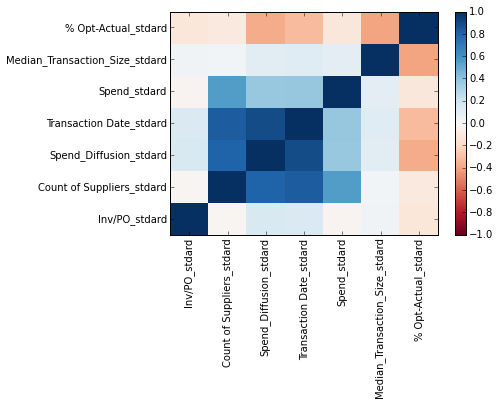

In [8]:
#Correlation between features.
#+1 is total positive correlation. -1 is total negative. 0 is no correlation.
corr = Dept_Analysis_Features.corr()

#Plot correlation
plt.pcolor(corr, cmap='RdBu', vmin=-1, vmax=1)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns, rotation='vertical')
plt.colorbar()
plt.show()

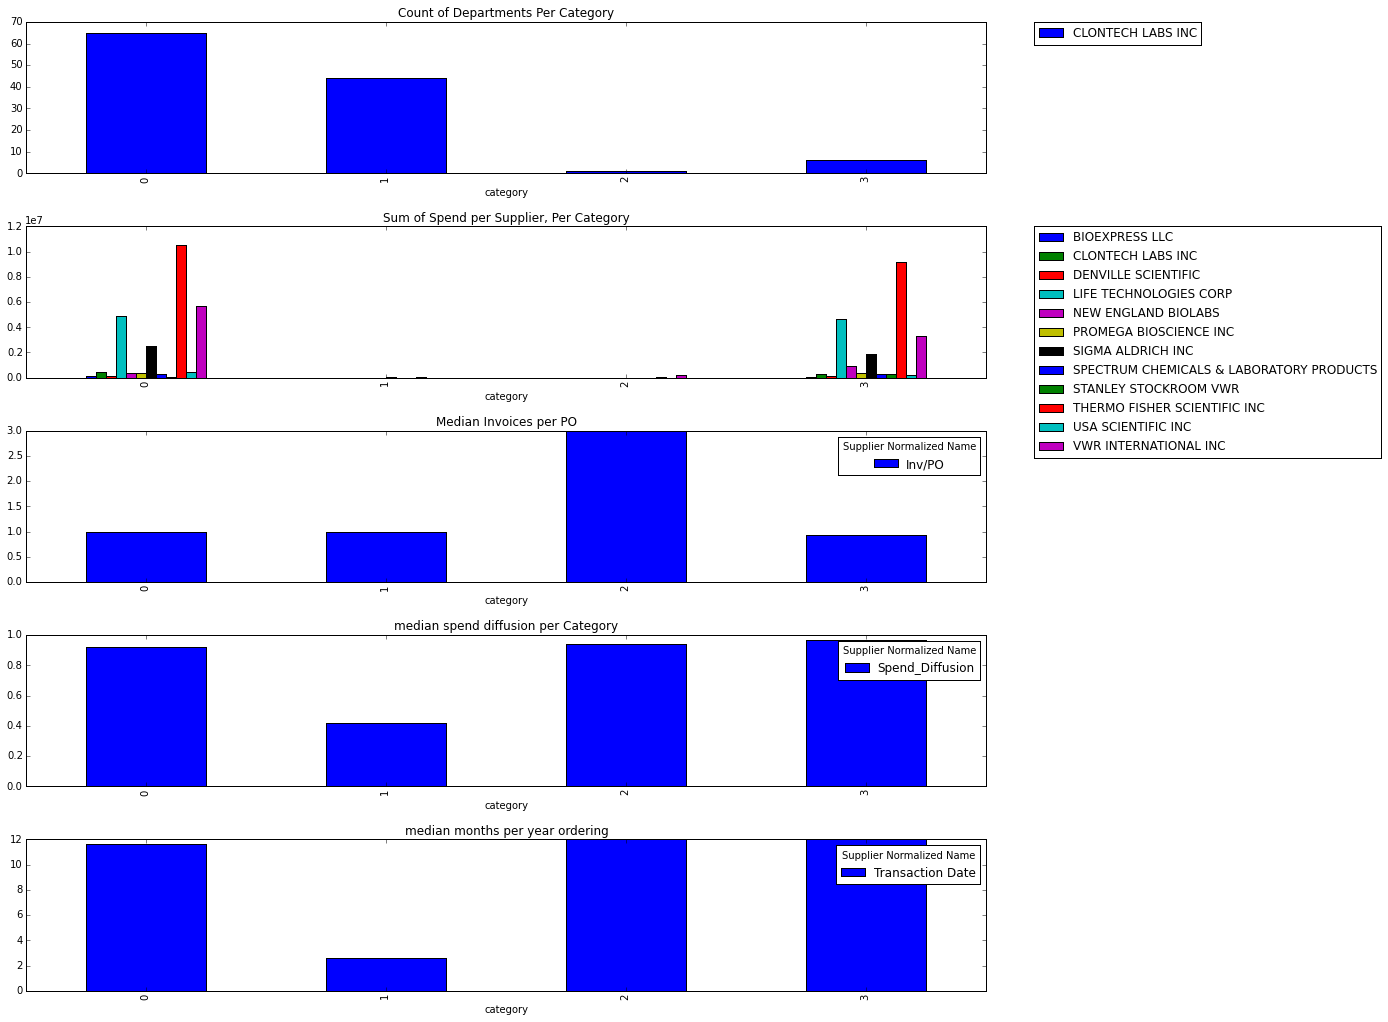

In [44]:
#Drop the category column if it exists
for col in Department_Analysis.columns:
    if col is 'category':
        Department_Analysis = Department_Analysis.drop(col,1)

#Run the heirarchical clustering
agglomerativeClustering = AgglomerativeClustering(n_clusters=4)
Department_Analysis['category'] = agglomerativeClustering.fit_predict(Dept_Analysis_Features)

#Group the data by supplier and plot it to see the spend per supplier/per cluster.
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(14, 14))
fig.tight_layout()
fig.subplots_adjust(hspace=.35)
ax1 = Department_Analysis.groupby('category').count()[[1]].plot(kind='bar',ax=axes[0], title='Count of Departments Per Category', label=None).legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax2 = Department_Analysis.groupby('category').sum()[[x for x in Department_Analysis.columns[0:N_Suppliers]]].plot(kind='bar',ax=axes[1], title='Sum of Spend per Supplier, Per Category').legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax3 = Department_Analysis.groupby('category').median()[['Inv/PO']].plot(kind='bar',ax=axes[2], title='Median Invoices per PO')
ax3.set_ylim(0,3)
ax4 = Department_Analysis.groupby('category').median()[['Spend_Diffusion']].plot(kind='bar',ax=axes[3], title='median spend diffusion per Category')
ax4.set_ylim(0,1)
ax5 = Department_Analysis.groupby('category').mean()[['Transaction Date']].plot(kind='bar',ax=axes[4], title='median months per year ordering')

In [10]:
Department_Analysis[Department_Analysis['category']==1]

Supplier Normalized Name               BIOEXPRESS LLC  CLONTECH LABS INC  \
Campus Org Level 3                                                         
UCB    Academic Senate                              0                  0   
       Art Mus & Pacific Film Archive               0                  0   
       Cal Performances_SMA                         0                  0   
       Campus Support Core                          0                  0   
       Col of Environmental Design                  0                  0   
       Facilities Services                          0                  0   
       Goldman Sch of Public Policy                 0                  0   
       Graduate School of Education                 0                  0   
       Real Estate                                  0                  0   
       School of Journalism                         0                  0   
       School of Social Welfare                     0                  0   
       Strategic Acad and Fac Plan                  0                  0   
       UC Library                                   0                  0   
       University Extension                         0                  0   
       University Relations                         0                  0   
       VP Divisionwide Prov & Expense               0                  0   
UCSF   Adult Psychiatry Clinic                      0                  0   
       C_Chancellor's Reportable Exps               0                  0   
       E_EVC&P Direct Office                        0                  0   
       E_Library                                    0                  0   
       F_CLS AVC                                    0                  0   
       F_CLS FM Util Svc Ops                        0                  0   
       F_FIN Controllers Office                     0                  0   
       F_HR Human Resources                         0                  0   
       F_IT Info Tech Svcs                          0                  0   
       MC UCOP Budget Reporting                     0                  0   
       M_Anthro, History, Social Med                0                  0   
       M_Asthma Program                             0                  0   
       M_Computational Health Scienc                0                  0   
       M_Ctr for Health & Community                 0                  0   
       M_Emergency Medicine                         0                  0   
       M_Graduate Med Science Unit                  0                  0   
       M_IHPS (Health Policy Studies)               0                  0   
       M_Miscellaneous Programs                     0                  0   
       M_Osher Center                               0                  0   
       M_School Level Holding                       0                  0   
       N_Community Health Systems                   0                  0   
       N_Dean's Office                              0                  0   
       N_Family Health Care Nursing                 0                  0   
       P_Dean's Office                              0                  0   
       Pathology                                    0                  0   
       RESEARCH RESOURCE PROGRAM                    0                  0   
       V_Dev Operations                             0                  0   
       W_Resource Management                        0                  0   

Supplier Normalized Name               DENVILLE SCIENTIFIC  \
Campus Org Level 3                                           
UCB    Academic Senate                                   0   
       Art Mus & Pacific Film Archive                    0   
       Cal Performances_SMA                              0   
       Campus Support Core                               0   
       Col of Environmental Design                       0   
       Facilities Services                               0   
       

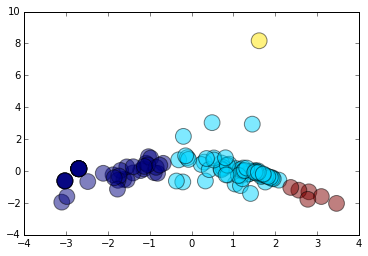

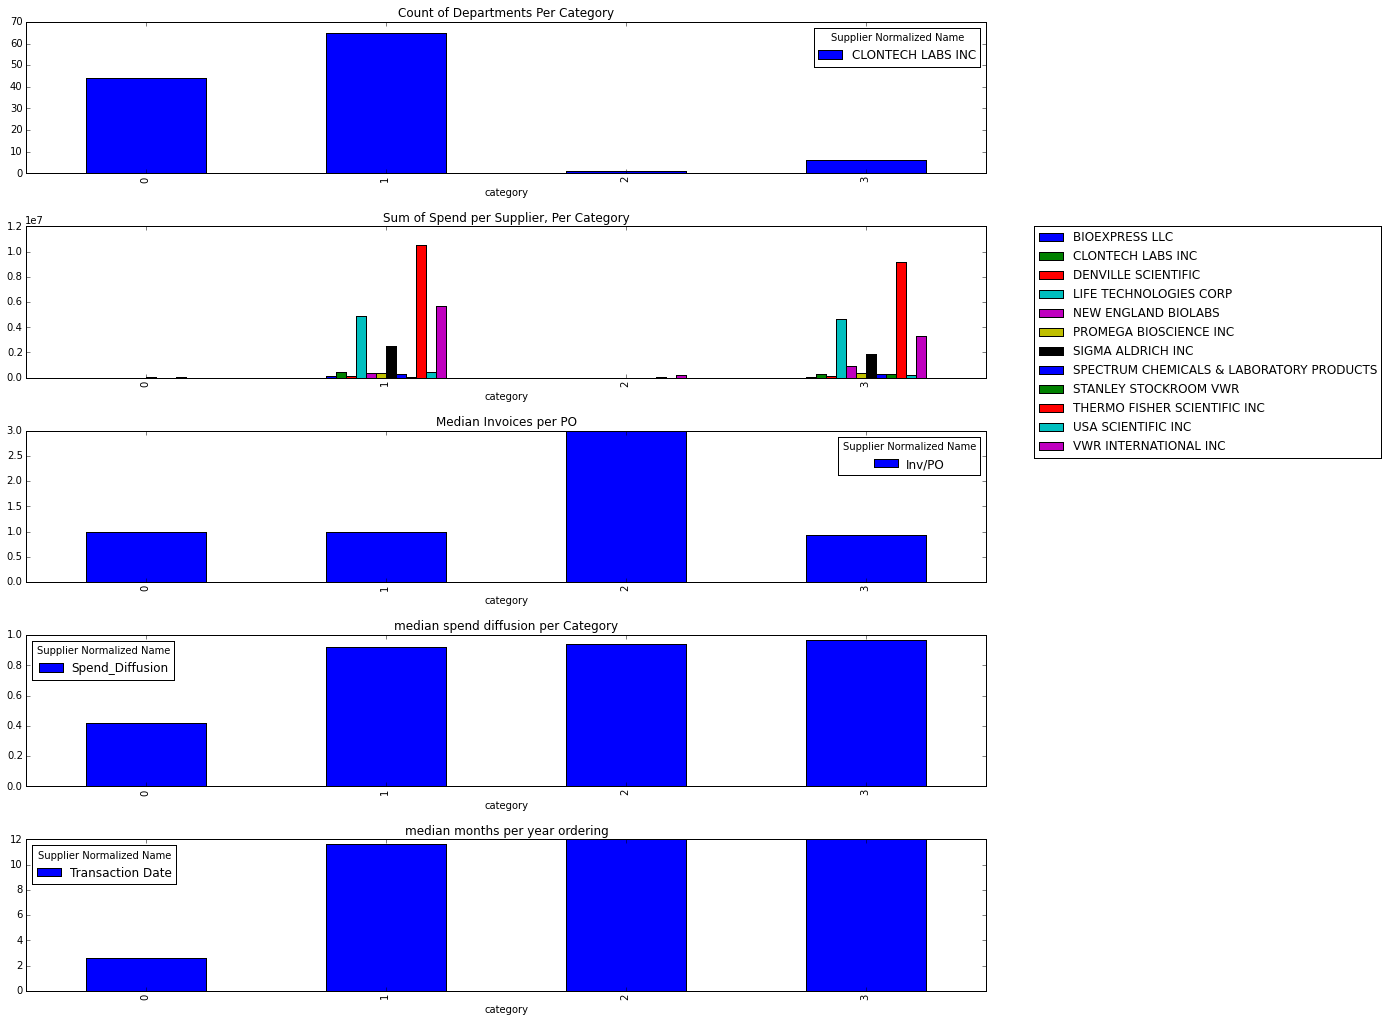

In [46]:
#Use PCA to reduce dimensionality to 2 to check the variance explained and inspect the clusters
pca = PCA(n_components=3).fit_transform(Dept_Analysis_Features)
pcaT = PCA(n_components=3).fit(Dept_Analysis_Features)


#Run KMeans clustering
kmeans = KMeans(n_clusters=4)
Department_Analysis['category'] = kmeans.fit_predict(Dept_Analysis_Features)

#Run PCA and chart the two leading Components to see what the clusters look like in 2D space
sc = plt.scatter(pca[:,0],pca[:,1], s=250, c=Department_Analysis.category, alpha=0.5, edgecolors='black')
plt.legend()
plt.show()

#Group the data by supplier and plot it to see the spend per supplier/per cluster.
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(14, 14))
fig.tight_layout()
fig.subplots_adjust(hspace=.35)
ax1 = Department_Analysis.groupby('category').count()[[1]].plot(kind='bar',ax=axes[0], title='Count of Departments Per Category', label=None)
ax2 = Department_Analysis.groupby('category').sum()[[x for x in Department_Analysis.columns[0:N_Suppliers]]].plot(kind='bar',ax=axes[1], title='Sum of Spend per Supplier, Per Category').legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax3 = Department_Analysis.groupby('category').median()[['Inv/PO']].plot(kind='bar',ax=axes[2], title='Median Invoices per PO')
ax3.set_ylim(0,3)
ax4 = Department_Analysis.groupby('category').median()[['Spend_Diffusion']].plot(kind='bar',ax=axes[3], title='median spend diffusion per Category')
ax4.set_ylim(0,1)
ax5 = Department_Analysis.groupby('category').mean()[['Transaction Date']].plot(kind='bar',ax=axes[4], title='median months per year ordering')